# Astro Hack Week

The goal is to create an automated Voigt profile model to high resolution astrophysical spectra.

This notebook aims to show the current state.

In [10]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import numpy as np
import emcee
import copy
import corner
import pandas as pd
import os, sys
import warnings
import string
import astropy
import pymc as mc
import itertools as it
from glob import glob
import datetime

import barak
from barak import absorb
from barak import convolve
from barak import voigt
from barak import pyvpfit

In [11]:
warnings.simplefilter("ignore")
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_context('poster', font_scale=1.3)

In [12]:
atomDict = absorb.readatom('../data/MM_VPFIT_2012-06-05_noiso.dat')
pixel_size = 1.3 # km/s per pixel
subsample_factor = int(1)

In [13]:
def VoigtAbsorption(x):
    return np.exp(-x)

def subsample(wave, subsample_factor=subsample_factor, pixel_size=pixel_size):
    # Assumes wave was created by make_constant_dv_wa_scale
    # pixel_size is in km/s of the original wave array
    begin_size = wave[1] - wave[0]
    end_size = wave[-1] - wave[-2]
    subwave = barak.sed.make_constant_dv_wa_scale(wave[0] - begin_size/2.0, wave[-1] + end_size, pixel_size/subsample_factor)
    return subwave[:len(wave) * subsample_factor]

def co_add_from_subsample(subsampled_flux, subsample_factor=subsample_factor):
    starting_length = len(subsampled_flux)
    intermediate_step = subsampled_flux.reshape(starting_length/subsample_factor, subsample_factor)/float(subsample_factor)
    return np.sum(intermediate_step, axis=1)

def create_wavelength_chunk(rest_wavelength, z_begin, z_end, pixel_size=1.3, tolerance=2.0):
    """Returns a wavelength array that covers the redshift range of interest
    for a given transition.
    pixel_size in km/s
    tolerance in Angstroms."""
    starting = (z_begin + 1 ) * rest_wavelength
    ending = (z_end + 1 ) * rest_wavelength
    return barak.sed.make_constant_dv_wa_scale(starting - tolerance, ending + tolerance, pixel_size)


In [14]:
onesigmaerror = 0.02
#onesigmaerror = np.average(err1)
instrument_profile = 5.0 #km/s
estimated_instrument_profile = 5.0

z_lower = 1.6272486
z_upper = 1.6322109
b_lower = 2.0
b_upper = 10.5
N_lower = 9.5
N_upper = 13.0
line_list = []

species = {}
species['FeII'] = {}
species['FeII']['1608'] = 1608.4507986
# species['FeII']['1611'] = 1611.2004037
species['FeII']['2382'] = 2382.7640777
species['FeII']['2600'] = 2600.1721140
species['FeII']['2344'] = 2344.2127470
# species['FeII']['2586'] = 2586.6493120
# species['AlII'] = {}
# species['AlII']['1670'] = 1670.7886100 

# species['AlIII'] = {}
# species['AlIII']['1862'] = 1862.798581
# species['AlIII']['1854'] = 1854.708966

# species['MgI'] = {}
# species['MgI']['2852'] = 2852.9627970

# species['MgII'] = {}
# species['MgII']['2796'] = 2796.3537860
# species['MgII']['2803'] = 2803.5309820


In [15]:
regions = []
wavelength_list = []
for specie in species:
    for transition in species[specie]:
        rest_wavelength = species[specie][transition]
        wave = create_wavelength_chunk(rest_wavelength, z_lower, z_upper)
        wavelength_list.append(wave)
        regions.append([specie, transition, np.average(wave)])
        
wavelength_list = np.array(wavelength_list)
wavelength = np.array(np.hstack(wavelength_list))
subwavelength_list = []
for cutwave in wavelength_list:
    subwavelength_list.append(subsample(cutwave))
subwavelength_list = np.array(subwavelength_list)

noise_list = np.array([np.random.normal(0.0, onesigmaerror, len(wave)) for wave in wavelength_list])
noise = np.hstack(noise_list)


In [16]:
# This is when you want to tie species together with fixed relative column densities
species_column_density_correction = {}
species_column_density_correction["MgI"] = -1.72
species_column_density_correction["MgII"] =  0.08
species_column_density_correction["AlII"] = -1.02
species_column_density_correction["AlIII"] = -1.62
species_column_density_correction["SiII"] =  0.06
species_column_density_correction["CrII"] = -1.82
species_column_density_correction["FeII"] =  0.00
species_column_density_correction["MnII"] = -1.97
species_column_density_correction["NiII"] = -1.25
species_column_density_correction["TiII"] = -1.54
species_column_density_correction["ZnII"] = -1.82

In [17]:
srdjan = """   
   FeII     11.17750     1.1468580LA   10.3409LA    -7.225QA      0.00   0.00E+00  0 !   76
   FeII     11.83229     1.1469670LC    4.9641LC    -7.225QA      0.00   0.00E+00  0 !   77
   FeII     12.19314     1.1469657LD    2.5613LD    -7.225QA      0.00   0.00E+00  0 !   78
   FeII     11.52912     1.1469940LF    2.7083LF    -7.225QA      0.00   0.00E+00  0 !   79
   FeII     11.42333     1.1470254LG    2.3740LG    -7.225QA      0.00   0.00E+00  0 !   80
   FeII     10.64392     1.1470493LH    1.9728LH    -7.225QA      0.00   0.00E+00  0 !   81
   FeII     11.92450     1.1471106LI    6.1052LI    -7.225QA      0.00   0.00E+00  0 !   82
   FeII     11.35914     1.1471500LJ    3.0018LJ    -7.225QA      0.00   0.00E+00  0 !   83
   FeII     11.50212     1.1471766LK    2.5904LK    -7.225QA      0.00   0.00E+00  0 !   84
   FeII     10.47751     1.1472015LL    4.5873LL    -7.225QA      0.00   0.00E+00  0 !   85
   FeII     11.77955     1.1472415LM    2.9827LM    -7.225QA      0.00   0.00E+00  0 !   86
   FeII     11.51390     1.1472864LO    5.2146LO    -7.225QA      0.00   0.00E+00  0 !   87
   FeII     10.94020     1.1473725LP   14.7310LP    -7.225QA      0.00   0.00E+00  0 !   88
   FeII     11.89655     1.1474161LR    3.6218LR    -7.225QA      0.00   0.00E+00  0 !   89
   FeII     11.22069     1.1475825LU    5.1018LU    -7.225QA      0.00   0.00E+00  0 !   90
   FeII     10.18773     1.1476086LV    5.5240LV    -7.225QA      0.00   0.00E+00  0 !   91
   FeII     11.86228     1.1478073LY    2.3796LY    -7.225QA      0.00   0.00E+00  0 !   92
   FeII     10.46826     1.1478320LZ    1.4068LZ    -7.225QA      0.00   0.00E+00  0 !   93
   FeII     11.65667     1.1479169AA    6.9106AA    -7.225QA      0.00   0.00E+00  0 !   94
   FeII     11.54438     1.1479104AB    1.7705AB    -7.225QA      0.00   0.00E+00  0 !   95
   FeII     12.04687     1.1479772AD    3.4630AD    -7.225QA      0.00   0.00E+00  0 !   96
   FeII     10.89965     1.1480106AE    4.6401AE    -7.225QA      0.00   0.00E+00  0 !   97
   FeII     11.19271     1.1480686AF    2.7318AF    -7.225QA      0.00   0.00E+00  0 !   98
   FeII     11.64764     1.1481107AG    3.0581AG    -7.225QA      0.00   0.00E+00  0 !   99
   FeII     11.31744     1.1483368CC   15.9645CC    -4.496QA      0.00   0.00E+00  0 !   63
   FeII     10.79378     1.1484427CD    4.3089CD    -4.496QA      0.00   0.00E+00  0 !   64
   FeII     11.46476     1.1484981CE    6.0623CE    -4.496QA      0.00   0.00E+00  0 !   65
   FeII     11.01125     1.1485450CF    8.3700CF    -4.496QA      0.00   0.00E+00  0 !   66
   FeII     11.25117     1.1486498CH    9.1910CH    -4.496QA      0.00   0.00E+00  0 !   67
   FeII     11.23297     1.1487849CI    4.3267CI    -4.496QA      0.00   0.00E+00  0 !   68
   FeII     11.05535     1.1488972CJ    6.5947CJ    -4.496QA      0.00   0.00E+00  0 !   69
   FeII     11.91067     1.1490852CM    6.3192CM    -4.496QA      0.00   0.00E+00  0 !   70
   FeII     12.57178     1.1490880CN    2.2798CN    -4.496QA      0.00   0.00E+00  0 !   71
   FeII     11.87767     1.1491232CO    1.3893CO    -4.496QA      0.00   0.00E+00  0 !   72
   FeII     11.99946     1.1491384CR    4.9761CR    -4.496QA      0.00   0.00E+00  0 !   73
   FeII     10.37379     1.1492246CS    3.7719CS    -4.496QA      0.00   0.00E+00  0 !   74
   FeII     11.10738     1.1493204CU   10.6410CU    -4.496QA      0.00   0.00E+00  0 !   75
   FeII     10.88345     1.1494234CV    3.4762CV    -4.496QA      0.00   0.00E+00  0 !   76
   FeII     12.08366     1.1494903CY    3.9032CY    -4.496QA      0.00   0.00E+00  0 !   77
   FeII     12.09241     1.1495403CZ    3.9433CZ    -4.496QA      0.00   0.00E+00  0 !   78
   FeII     11.46621     1.1495795MA    3.5760MA    -4.496QA      0.00   0.00E+00  0 !   79
   FeII     11.17768     1.1497143MB    8.2904MB    -4.496QA      0.00   0.00E+00  0 !   80
   FeII     12.02913     1.1498162MD    3.5172MD    -4.496QA      0.00   0.00E+00  0 !   81
   FeII     10.99304     1.1498186ME    4.9302ME    -4.496QA      0.00   0.00E+00  0 !   82
   FeII     11.98416     1.1499112MF    4.4276MF    -4.496QA      0.00   0.00E+00  0 !   83
   FeII     11.09972     1.1499513MG    3.9170MG    -4.496QA      0.00   0.00E+00  0 !   84
   FeII     10.48134     1.1502300ra    2.2300ra    -0.920qa      0.00   1.00E+00  0 !    1
   FeII     10.65566     1.1502512rb    8.1558rb    -0.920QA      0.00   1.00E+00  0 !    2
   FeII     10.95794     1.1503526rc    4.2185rc    -0.920QA      0.00   1.00E+00  0 !    3
   FeII     10.32692     1.1503954rd    1.0000rd    -0.920QA      0.00   1.00E+00  0 !    4
   FeII     11.25157     1.1504147re    3.4995re    -0.920QA      0.00   1.00E+00  0 !    5
   FeII     11.31817     1.1504944rf    6.0939rf    -0.920QA      0.00   1.00E+00  0 !    6
   FeII     11.27728     1.1505416rh    2.5104rh    -0.920QA      0.00   1.00E+00  0 !    7
   FeII     11.37752     1.1505613ri    3.3166ri    -0.920QA      0.00   1.00E+00  0 !    8
   FeII     11.52086     1.1506299rj    3.9995rj    -0.920QA      0.00   1.00E+00  0 !    9
   FeII     11.47810     1.1506520rk    2.4440rk    -0.920QA      0.00   1.00E+00  0 !   10
   FeII     12.02071     1.1506735rl    1.4355rl    -0.920QA      0.00   1.00E+00  0 !   11
   FeII     12.23045     1.1506898rm    1.7383rm    -0.920QA      0.00   1.00E+00  0 !   12
   FeII     12.47664     1.1507134rn    3.8310rn    -0.920QA      0.00   1.00E+00  0 !   13
   FeII     12.55932     1.1507511ro    2.4034ro    -0.920QA      0.00   1.00E+00  0 !   14
   FeII     12.74720     1.1507857rp    1.0000rp    -0.920QA      0.00   1.00E+00  0 !   15
   FeII     13.36851     1.1507929rq    2.8715rq    -0.920QA      0.00   1.00E+00  0 !   16
   FeII     12.55832     1.1508208rr    1.0000rr    -0.920QA      0.00   1.00E+00  0 !   17
   FeII     12.69820     1.1508391rs    1.3730rs    -0.920QA      0.00   1.00E+00  0 !   18
   FeII     12.96667     1.1508624rt    1.1084rt    -0.920QA      0.00   1.00E+00  0 !   19
   FeII     12.76513     1.1508771ru    2.7753ru    -0.920QA      0.00   1.00E+00  0 !   20
   FeII     12.47171     1.1509096rv    2.1634rv    -0.920QA      0.00   1.00E+00  0 !   21
   FeII     12.73342     1.1509356rw    2.1817rw    -0.920QA      0.00   1.00E+00  0 !   22
   FeII     13.31940     1.1509672rx    3.2003rx    -0.920QA      0.00   1.00E+00  0 !   23
   FeII     12.58964     1.1509702ry    4.3817ry    -0.920QA      0.00   1.00E+00  0 !   24
   FeII     12.98250     1.1510508rz    5.2050rz    -0.920QA      0.00   1.00E+00  0 !   25
   FeII     12.30096     1.1510787db    1.0000db    -0.920QA      0.00   1.00E+00  0 !   26
   FeII     12.17592     1.1511015dc    1.0000dc    -0.920QA      0.00   1.00E+00  0 !   27
   FeII     12.27888     1.1511165dd    2.6517dd    -0.920QA      0.00   1.00E+00  0 !   28
   FeII     12.37217     1.1511447de    2.9818de    -0.920QA      0.00   1.00E+00  0 !   29
   FeII     12.38620     1.1511685dg    2.2560dg    -0.920QA      0.00   1.00E+00  0 !   30
   FeII     12.54494     1.1511939dh    3.7126dh    -0.920QA      0.00   1.00E+00  0 !   31
   FeII     12.86855     1.1512189di    3.4890di    -0.920QA      0.00   1.00E+00  0 !   32
   FeII     13.06734     1.1512634dj    5.1260dj    -0.920QA      0.00   1.00E+00  0 !   33
   FeII     12.73812     1.1512847dk    2.2481dk    -0.920QA      0.00   1.00E+00  0 !   34
   FeII     13.11318     1.1513117dl    2.7588dl    -0.920QA      0.00   1.00E+00  0 !   35
   FeII     12.99531     1.1513405dm    2.3542dm    -0.920QA      0.00   1.00E+00  0 !   36
   FeII     12.48565     1.1513545dn    3.0269dn    -0.920QA      0.00   1.00E+00  0 !   37
   FeII     12.38910     1.1513831do    3.9872do    -0.920QA      0.00   1.00E+00  0 !   38
   FeII     11.93011     1.1514192dp    5.6347dp    -0.920QA      0.00   1.00E+00  0 !   39
   FeII     12.13247     1.1514580dq    4.9248dq    -0.920QA      0.00   1.00E+00  0 !   40
   FeII     11.03849     1.1514812dr    1.0000dr    -0.920QA      0.00   1.00E+00  0 !   41
   FeII     11.07134     1.1515084ds    1.0000ds    -0.920QA      0.00   1.00E+00  0 !   42
   FeII     11.53046     1.1515361dt    4.1873dt    -0.920QA      0.00   1.00E+00  0 !   43
   FeII     11.09424     1.1515925du    4.4079du    -0.920QA      0.00   1.00E+00  0 !   44
   FeII     10.94804     1.1516208dv    1.6510dv    -0.920QA      0.00   1.00E+00  0 !   45
   FeII     10.63109     1.1516630dw    1.2394dw    -0.920QA      0.00   1.00E+00  0 !   46
   FeII     11.01413     1.1516361dx   10.7889dx    -0.920QA      0.00   1.00E+00  0 !   47
   FeII     10.51808     1.1517528dy    1.0000dy    -0.920QA      0.00   1.00E+00  0 !   48
   FeII     11.27135     1.1517689dz    6.1324dz    -0.920QA      0.00   1.00E+00  0 !   49
 """
starting_model = []
for line in srdjan.splitlines():
    line = line.split()
    if len(line) > 0:
        ion = line[0]
        ncol = np.clip(float(line[1]) + 1.5, 7, 13.1)
        redshift = float(line[2][:-2])
        bval = float(line[3][:-2])
        starting_model.append([ion, ncol, redshift + 0.4801, bval])

# starting_model

In [18]:
# starting_model = [
# #  ['FeII', 11.47903, 1.6272486, 5.8986],
# #  ['FeII', 11.80684, 1.6273509, 4.9074],
# #  ['FeII', 12.04197, 1.6274293, 4.2774],
#  ['FeII', 12.53468, 1.6274744, 3.7264],
#  ['FeII', 11.81651, 1.6275073, 3.0    ],
#  ['FeII', 11.8325,  1.6275375, 2.036 ],
#  ['FeII', 11.98327, 1.6275711, 4.9331],
#  ['FeII', 12.53598, 1.6276858, 3.9991],
# #  ['FeII', 12.37782, 1.6277142, 2.9156],
# #  ['FeII', 12.04839, 1.6277377, 4.4162],
# #  ['FeII', 12.14221, 1.6277991, 4.0641],
# #  ['FeII', 12.60239, 1.6278632, 4.2045],
# #  ['FeII', 12.4193,  1.6279151, 2.5551],
# #  ['FeII', 12.84099, 1.6279648, 3.9983],
# #  ['FeII', 11.9488,  1.628003,  1.1738],
# #  ['FeII', 12.28364, 1.6280408, 3.766 ],
# #  ['FeII', 11.72462, 1.6280943, 1.0938],
# #  ['FeII', 11.49827, 1.6281306, 1.0164],
# #  ['FeII', 11.08618, 1.6281681, 1.0   ],
# #  ['FeII', 12.00147, 1.6282109, 8.2485],
# ]
true_components = len(starting_model)

In [19]:
true_component_parameters = []
for row in starting_model:
    for specie in species:
        true_component_parameters.append([specie, row[2], row[3], row[1] + species_column_density_correction[specie]])

In [20]:
gen_data = {}
for region_index, region_wavelength in enumerate(wavelength_list):
    gen_data[region_index] = {}
    flux = absorb.find_tau(subwavelength_list[region_index], true_component_parameters, atomDict, )[0]
    gen_data[region_index] = co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux), 
                                                                                     instrument_profile)) + noise_list[region_index]
total_observed = np.hstack([gen_data[region_index]
                            for region_index, region_wavelength in enumerate(wavelength_list)])

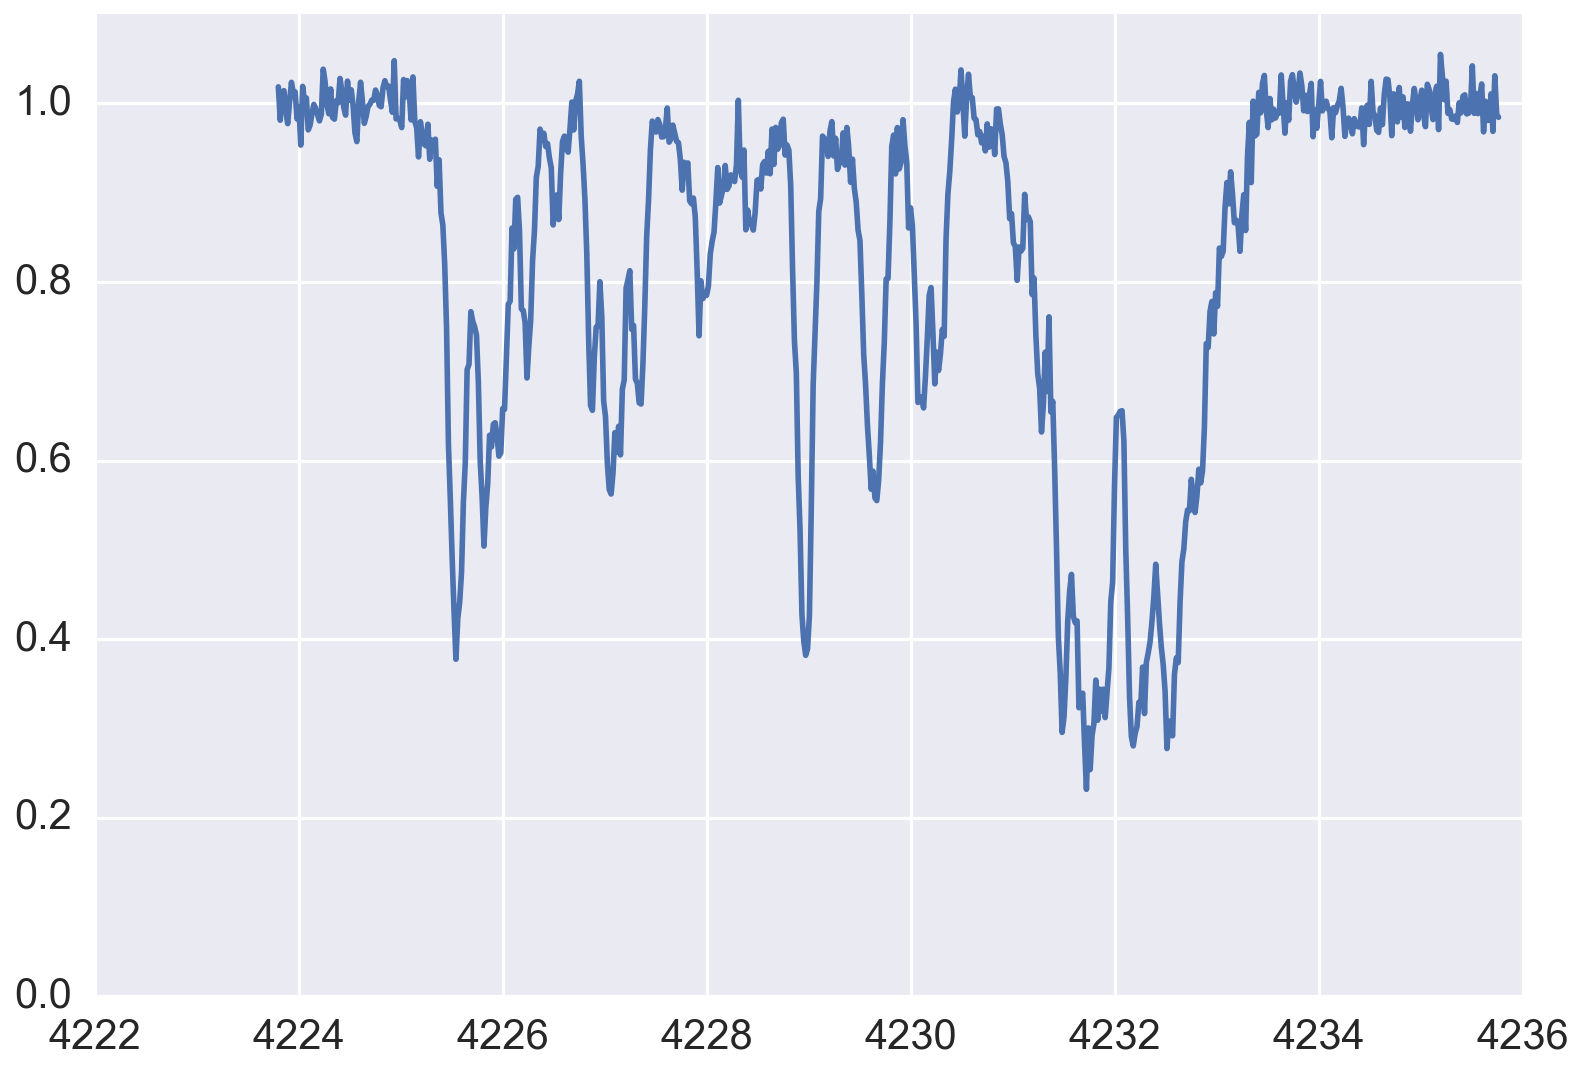

In [21]:
index = 0
plt.plot(wavelength_list[index], gen_data[index])
plt.ylim(0, 1.1);

In [22]:
timestamp = "astrohack"

In [107]:
# # Write spectra files
# wavelength_buffer = 2.0
# lower_labels = []
# for x in it.combinations_with_replacement(string.ascii_lowercase, 2):
#     lower_labels.append(x[0] + x[1])


# for i, region in enumerate(wavelength_list):
#     np.savetxt(timestamp + "." + str(i) + regions[i][0] + ".ascii",
#                (np.transpose([wavelength_list[i], gen_data[i], np.ones_like(region) * onesigmaerror])))


In [16]:
# # Read spectra
# leader_ion = "FeII"
# wavelength_list = []
# observed = []
# noise_list = []
# for infile in sorted(glob(timestamp + "*" + leader_ion + ".ascii")):
#     wav, flx, err = np.loadtxt(infile, unpack=True)
#     wavelength_list.append(wav)
#     observed.append(flx)
#     noise_list.append(err)

# err = np.hstack(noise_list)
# total_observed = np.hstack(observed)
# subwavelength_list = []
# for cutwave in wavelength_list:
#     subwavelength_list.append(subsample(cutwave))

# subwavelength_list = np.array(subwavelength_list)

In [17]:
np.min([mod[3] for mod in starting_model]), np.max([mod[3] for mod in starting_model])

(1.0, 15.964499999999999)

In [6]:
#fit_species = "FeII"
fit_components = 35
N_tol = 0.1
b_tol = 0.1
z_tol = 0.00001
ip_tol = 0.5
estimated_variables = {}
fit_N_lower = 9.5
fit_N_upper = 13.5
fit_b_lower = 2.00
fit_b_upper = 15.0
fit_z_lower = 1.626079
fit_z_upper = z_upper + z_tol
# Instrument profile
fit_instrument_profile_lower = instrument_profile - ip_tol
fit_instrument_profile_upper = instrument_profile + ip_tol

estimated_variables = {}
for index, redshift in enumerate(np.linspace(fit_z_lower, fit_z_upper, num=fit_components)):
    component = index
    estimated_variables[component] = {}
    estimated_variables[component]['fit_b'] = mc.Uniform("est_b_" + str(component), fit_b_lower, fit_b_upper)
    estimated_variables[component]['fit_z'] = mc.Uniform("est_z_" + str(component), fit_z_lower, fit_z_upper, value=redshift)

#estimated_instrument_profile = mc.Uniform("est_IP", fit_instrument_profile_lower, fit_instrument_profile_upper)
estimated_instrument_profile = instrument_profile

#std deviation of the noise, converted to precision by tau = 1/sigma**2
#std_deviation = 1./mc.Uniform("std", 0, 1)**2
#std_deviation = 1./(noise**2)
std_deviation = 1./(noise**2)

NameError: name 'z_upper' is not defined

In [19]:
physical_fit_components = []
#for index, redshift in enumerate(np.linspace(fit_z_lower, fit_z_upper, num=fit_components)):
for component in range(fit_components):
    physical_fit_components.append([estimated_variables[component]['fit_z'],
                                    estimated_variables[component]['fit_b']])

regions = []
for specie in species:
    for transition in species[specie]:
        rest_wavelength = species[specie][transition]
        wave = create_wavelength_chunk(rest_wavelength, z_lower, z_upper)
        regions.append([specie, transition, np.average(wave)])

fit_component_parameters = []
for index in range(fit_components):
    component = index
    for specie in species:
        fit_component_parameters.append([specie,
                                         physical_fit_components[component][0],
                                         physical_fit_components[component][1],
                                         mc.Uniform("est_N_" + specie + "_" + str(component),
                                                    fit_N_lower,
                                                    fit_N_upper)])


In [20]:
@mc.deterministic(trace=False)
def generated_flux(regions=len(wavelength_list), 
                   fit_component_guesses=fit_component_parameters,
                   fit_instrument_profile=estimated_instrument_profile):
    """Creates the absorption for the components"""
    fit_flux = []
    for region_index in range(regions):
        flux = absorb.find_tau(subwavelength_list[region_index], fit_component_guesses, atomDict, )[0]
        fit_flux.append(co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux), fit_instrument_profile)))
    return np.hstack(fit_flux)


In [21]:
def generated_flux2(regions=len(wavelength_list), 
                   fit_component_guesses=fit_component_parameters,
                   fit_instrument_profile=estimated_instrument_profile):
    """Creates the absorption for the components"""
    fit_flux = []
    for region_index in range(regions):
        flux = absorb.find_tau(subwavelength_list[region_index], fit_component_guesses, atomDict, )[0]
        fit_flux.append(co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux), fit_instrument_profile)))
    return np.hstack(fit_flux)


In [22]:
potentials = {}
for component in range(fit_components - 1):
    @mc.potential
    def order_restriction(m1=estimated_variables[component]['fit_z'], 
                          m2=estimated_variables[component + 1]['fit_z']):
        if m1 < m2:
            return 0
        else:
            return 1 - np.exp(100000. * (m1 - m2))
    potentials[component] = order_restriction


In [23]:
observations = mc.Normal("obs", generated_flux, std_deviation, value=total_observed, observed=True)

In [24]:
m1 = mc.Model(list(set([x[1] for x in fit_component_parameters]))
              + list(set([x[2] for x in fit_component_parameters]))
              + list(set([x[3] for x in fit_component_parameters]))
              + [std_deviation]
              + [potentials[restriction] for restriction in potentials]
#               + [estimated_instrument_profile]
             )


In [25]:
# map_ = mc.MAP(m1)
# first_fit = datetime.datetime.now()
# map_.fit()
# print("Initial fit time: ", str(datetime.datetime.now() - first_fit))

In [26]:
m_sample = mc.MCMC(m1)

In [25]:
# starttime = datetime.datetime.now()
# print("Starting time: ", starttime)
# iterations = 100
# burn=10
# thin=10.0
# # %prun
# m_sample.sample(iter=iterations, burn=burn, thin=thin)
# finishtime = datetime.datetime.now()
# sampletime = str(finishtime - starttime)
# print("\nTook:", sampletime, " to finish", str(iterations), "iterations.")

In [ ]:
final_fit = []
for row in fit_component_parameters:
    final_fit.append([row[0], row[1].value, row[2].value, row[3].value])

final_fit = sorted(final_fit, key=lambda x:x[1])

fit_flux = {}
for region_index, region_wavelength in enumerate(wavelength_list):
    fit_flux[region_index] = {}
    flux = absorb.find_tau(subwavelength_list[region_index], final_fit, atomDict, )[0]
    fit_flux[region_index]['flux'] = co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux),
                                                                                 estimated_instrument_profile))

In [ ]:
for region_index, region_wavelength in enumerate(wavelength_list):
    print(region_index, len(region_wavelength))

In [25]:
x_formatter = mpl.ticker.ScalarFormatter(useOffset=False)

In [ ]:
final_fit

In [ ]:
# pdf = PdfPages(datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S.flux") + ".pdf")
for region_index, region_wavelength in enumerate(wavelength_list):
    f = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 1, height_ratios=[1, 2, 2])
    ax3 = plt.subplot(gs[2])
    ax1 = plt.subplot(gs[0], sharex=ax3)
    ax2 = plt.subplot(gs[1], sharex=ax3)
    ax1.plot(wavelength_list[region_index], (gen_data[region_index] - fit_flux[region_index]['flux']) / onesigmaerror)
    ax1.hlines(1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-')
    ax1.hlines(0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='black')
    ax1.hlines(-1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-')
    ax2.plot(wavelength_list[region_index], gen_data[region_index], label="Observed")
    ax2.plot(wavelength_list[region_index], fit_flux[region_index]['flux'], color='black', label="Fit")
    ax2.legend(loc='best')
    ax3.plot(wavelength_list[region_index], gen_data[region_index], label="Observed")
    for observed_index, row in enumerate(true_component_parameters):
        flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if observed_index == 0:
            ax3.plot(wavelength_list[region_index], flux, color="red", label="actual-subcomponents", linewidth=1.0)
        else:
            ax3.plot(wavelength_list[region_index], flux, color="red", linewidth=1.0)
    for final_index, row in enumerate(final_fit):
        flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if final_index == 0:
            ax3.plot(wavelength_list[region_index], flux, color="green", label="fit-subcomponents", linewidth=1.0)
        else:
            ax3.plot(wavelength_list[region_index], flux, color="green", linewidth=1.0)
    ax3.plot(wavelength_list[region_index], fit_flux[region_index]['flux'], color='black', label="Full fit")
    ax3.legend(loc='best')
    ax3.xaxis.set_major_formatter(x_formatter)
    xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    plt.setp(xticklabels, visible=False)
    f.tight_layout()
    f.subplots_adjust(hspace=.10)
    ax1.set_title(str(true_components) + "/" 
                  + str(fit_components) 
                  + " true/fit; " + str(iterations)+ "/" 
                  + str(burn) + "/" + str(thin) + " itr/brn/thn; time: " + sampletime)
#     pdf.savefig()
#     plt.close()
# pdf.close()


In [ ]:
sns.distplot(-m_sample.trace('deviance')[:]/2.0)

In [ ]:
trace_dict = []
fit_flux = {}
final_fit = {}
names = [parameter.__name__ for row in sorted(fit_component_parameters) for parameter in row[1:]]
[name for name in names]
for trace_number in np.arange(-len(m_sample.trace(name)[:]), 0):
    final_fit[trace_number] = []
    data = [m_sample.trace(name)[trace_number] for name in sorted(names, key=lambda x: x.split('_')[-1])]
    final_fit[trace_number].append([['FeII'] + x for x in list([np.array(blah) 
                                                  for blah in data[x:x+3]] for x in xrange(0, len(data), 3))])
    fit_flux[trace_number] = {}
    for region_index, region_wavelength in enumerate(wavelength_list):
        fit_flux[trace_number][region_index] = {}
        flux = absorb.find_tau(subwavelength_list[region_index], final_fit[trace_number][0], atomDict, )[0]
        fit_flux[trace_number][region_index]['flux'] = co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux),
                                                                                     estimated_instrument_profile))
    trace_dict.append(fit_flux)


In [ ]:
# pdf = PdfPages(datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S.flux") + ".pdf")


for region_index, region_wavelength in enumerate(wavelength_list):
    f = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 1, height_ratios=[1, 2, 2])
    ax3 = plt.subplot(gs[2])
    ax1 = plt.subplot(gs[0], sharex=ax3)
    ax2 = plt.subplot(gs[1], sharex=ax3)
    ax1.hlines(1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                 lw=0.5,)
    ax1.hlines(0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='black', 
                 lw=0.5,)
    ax1.hlines(-1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                 lw=0.5,)
    ax2.plot(wavelength_list[region_index], gen_data[region_index], label="Observed",
                 alpha=0.8,
                 lw=0.5,
            )
    ax2.legend(loc='best')
    ax3.plot(wavelength_list[region_index], gen_data[region_index], label="Observed", 
                 alpha=0.8,
                 lw=0.5,
            )
    for observed_index, row in enumerate(true_component_parameters):
        flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if observed_index == 0:
            ax3.plot(wavelength_list[region_index], flux, color="red", label="actual-subcomponents", 
                 lw=0.5,)
        else:
            ax3.plot(wavelength_list[region_index], flux, color="red", 
                 lw=0.5,)
    for trace_number in np.arange(-len(m_sample.trace(name)[:]), 0):
        for final_index, row in enumerate(final_fit[trace_number][0]):
            flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
            flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
#             if final_index == 0:
#                 ax3.plot(wavelength_list[region_index], flux, color="green", label="fit-subcomponents", linewidth=1.0)
#             else:
            ax3.plot(wavelength_list[region_index], flux, color="green", lw=0.5, alpha=0.1)
        ax1.plot(wavelength_list[region_index], (gen_data[region_index] - fit_flux[trace_number][region_index]['flux']) / onesigmaerror, 
                 lw=0.5,
                 c='k'
                )
        ax2.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                 alpha=0.3,
                 lw=0.5,
#                  label="Fit",
                )
        ax3.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                 lw=0.5,)
    ax3.legend(loc='best')
    ax3.xaxis.set_major_formatter(x_formatter)
    xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    plt.setp(xticklabels, visible=False)
    f.tight_layout()
    f.subplots_adjust(hspace=.10)
    ax1.set_title(str(true_components) + "/" 
                  + str(fit_components) 
                  + " true/fit; " + str(iterations)+ "/" 
                  + str(burn) + "/" + str(thin) + " itr/brn/thn; time: " + sampletime)
#     pdf.savefig()
#     plt.close()
# pdf.close()


# Enter emcee

This idea borrowed from: http://twiecki.github.io/blog/2013/09/23/emcee-pymc/

In [ ]:
m_sample.deviance

In [26]:
m = copy.copy(m_sample)
# m = copy.copy(m1)

In [27]:
# This is the likelihood function for emcee

# names = [x.__name__ for x in sorted(m.stochastics, key=lambda x: x.__name__)]
names = sorted([x.__name__ for x in sorted(m.stochastics, key=lambda x: x.__name__)], key=lambda x: x.split('_')[-1])
def lnprob(vals): # vals is a vector of parameter values to try
    # Set each random variable of the pymc model to the value
    # suggested by emcee
    for val, name in zip(vals, new_names):
        stochastic_dict[name].value = val
    try:
        m.logp
    except mc.ZeroProbability:
        return -np.inf
#     return m.logp
    return -m.deviance/2.0

# emcee parameters
ndim = len(m.stochastics)

In [28]:
def sortlist(stochastic):
    name = x.__name__
    comp = int(name.split('_')[-1])
    return (comp, name)

In [29]:
new_names = sorted([x.__name__ for x in sorted(m.stochastics, key=lambda x: x.__name__)], key=lambda x: int(x.split('_')[-1]))

In [30]:
temp_list = []
for x in m.stochastics:
    temp_list.append([x.__name__, x])
# valdict = dict(zip(names, vals))
stochastic_dict = dict(temp_list)

In [ ]:
# Find MAP
mc.MAP(m).fit()
start = np.empty(ndim)
for i, var in enumerate(new_names):
    start[i] = stochastic_dict[var].value
# for i, var in enumerate(sorted([x.__name__ for x in sorted(m.stochastics, key=lambda x: x.__name__)], key=lambda x: x.split('_')[-1])):
#     start[i] = var.value

In [ ]:
lnprob(start)

In [ ]:
m.logp()

In [ ]:
def best_pymc_to_emcee(fit):
    whatever = []
    for line in fit[0]:
        whatever.append(float(line[3]))
        whatever.append(float(line[2]))
        whatever.append(float(line[1]))
    return np.array(whatever)
# best_pymc_to_emcee(final_fit[-1])

In [27]:
# start = best_pymc_to_emcee(final_fit[-1])
start = np.array([ 12.00020824,   2.17459937,   1.62625233,   9.60849865,
         9.50899535,   1.62624891,  13.13457799,   3.59756899,
         1.62789266,  13.49998225,  12.34375237,   1.62806609,
        13.03578821,   2.00206281,   1.62823432,  12.50510978,
         7.36905659,   1.62842519,  13.19287778,   8.29978642,
         1.62859059,  12.9391747 ,  14.99852365,   1.62878887,
        12.67210523,   8.36384431,   1.62896931,  13.49845484,
         2.65637322,   1.62915454,  12.85593578,   7.30776586,
         1.62928786,  12.58462766,   9.01964663,   1.62952279,
        12.6494878 ,   2.03320194,   1.62632398,  13.42961347,
        14.9774389 ,   1.62969123,  13.3944591 ,   8.04666414,
         1.6299727 ,  12.65194855,   2.00019291,   1.63005317,
        13.49641621,   7.25817177,   1.63073157,  12.89290875,
        14.99952162,   1.63066106,  13.32984245,  14.99902344,
         1.63058206,  13.49977253,   5.8769864 ,   1.63082916,
        13.49992135,   7.802355  ,   1.63095776,  13.27169984,
        12.63034143,   1.63105902,  13.49861764,  14.99452185,
         1.63129496,  10.33519022,   9.50395613,   1.626417  ,
        13.49928446,  11.42933441,   1.63120473,  13.49893008,
         4.57173322,   1.63138312,  13.40566759,  14.99934408,
         1.63164288,  13.47221309,   9.08408607,   1.63155691,
        12.78672832,   4.21522637,   1.63186999,   9.50971299,
         7.99832452,   1.62688394,  12.92935689,  13.76316637,
         1.62701154,  13.49992248,  14.69795368,   1.62716286,
        13.49977346,  11.91024041,   1.62733376,  13.11208347,
         2.97033333,   1.62752415,  12.60782949,   4.39811366,   1.62766335])

In [32]:
newstart = []
for index, thing in enumerate(start):
    if not index % 3:
        newstart.append(np.average([thing, thing, thing, fit_N_lower, fit_N_upper ]))
    if not (index + 1) % 3:
        newstart.append(np.average([thing,thing, thing, fit_z_lower, fit_z_upper]))
    if not (index + 2) % 3:
        newstart.append(np.average([thing, thing, thing, fit_b_lower, fit_b_upper]))
# p1[:, 0] < 9.5
# p1[:, 0] > 13.0
# p1[:, 1] < 3.0
# p1[:, 1] > 7.5
# p1[:, 2] < 1.6272486
# p1[:, 2] > 1.6282109
newstart = np.array(newstart)

In [33]:
lnprob(newstart)

-1399921388.0013247

In [34]:
components = 35

In [35]:
nwalkers = 320
p1 = emcee.utils.sample_ball(newstart, np.array(components * [.04, 0.05, 0.00001]), size=nwalkers)
arg = []
for walker in p1:
    arg.append(lnprob(walker))
print(np.sum(np.isfinite(arg)))

320


In [36]:
lnprob(p1[2])

-1409117012.328521

In [ ]:
# components = 5
# zvals = np.random.rand(nwalkers * components) * (z_upper - z_lower) + z_lower
# bvals = np.random.rand(nwalkers * components) * (b_upper - b_lower) + b_lower
# nvals = np.random.rand(nwalkers * components) * (N_upper - N_lower) + N_lower

# p0 = np.column_stack([nvals, bvals, zvals])

In [ ]:
# [item for sublist in list([nvals[i], bvals[i], zvals[i]] for i in range(len(zvals))) for item in sublist]
# allvariables = [item for sublist in list([nvals[i], bvals[i], zvals[i]] for i in range(len(zvals))) for item in sublist]

In [ ]:
# p0 = [allvariables[ix:ix + 3 * components] for ix in xrange(0, len(allvariables), 3 * components)]

In [36]:
# instantiate sampler passing in the pymc likelihood function
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [37]:
from tqdm import tqdm

In [ ]:
# burn-in
pos, prob, state = sampler.run_mcmc(p1, 1000)
sampler.reset()

In [ ]:
final_position = sampler.chain[:, sampler.iterations - 1, :]

In [38]:
f = open("chain.dat", "w")
f.close()

In [39]:
multisampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=6)

In [ ]:
iterations = 50000
count = 0
for result in tqdm(multisampler.sample(p1, iterations=iterations, storechain=False), total=iterations):
    count += 1
    if count % 100 == 0:
        position = result[0]
        f = open("chain.dat", "a")
        for k in range(position.shape[0]):
            f.write("{0:5d} {1:s}\n".format(k, " ".join([str(x) for x in position[k]])))
        f.close()

  0%|          | 5/50000 [00:16<47:44:54,  3.44s/it]

In [68]:
multisampler.acceptance_fraction

array([ 0.13476263,  0.19448698,  0.16998469,  0.14088821,  0.11026034,
        0.11638591,  0.06125574,  0.09341501,  0.11332312,  0.05972435,
        0.05053599,  0.12710567,  0.18070444,  0.09647779,  0.11332312,
        0.14548239,  0.17611026,  0.16845329,  0.14548239,  0.11026034,
        0.15467075,  0.16539051,  0.15313936,  0.1179173 ,  0.13323124,
        0.13323124,  0.13169985,  0.16385911,  0.12863706,  0.06431853,
        0.16998469,  0.11026034,  0.09954058,  0.16232772,  0.15467075,
        0.13629403,  0.08728943,  0.13476263,  0.13016845,  0.15926493,
        0.16845329,  0.09035222,  0.18683002,  0.12557427,  0.13935681,
        0.1179173 ,  0.12251149,  0.13782542,  0.16385911,  0.14548239,
        0.13476263,  0.07503828,  0.12863706,  0.13629403,  0.14854518,
        0.15467075,  0.03981623,  0.13782542,  0.16385911,  0.14548239,
        0.14548239,  0.05972435,  0.143951  ,  0.14088821,  0.18683002,
        0.1424196 ,  0.1424196 ,  0.05053599,  0.14854518,  0.15

In [70]:
final_position = multisampler.chain[:, :]
final_position

array([], shape=(320, 0, 105), dtype=float64)

In [ ]:
iterations = 100000
with open('emcee-chain.txt', 'a') as file_handle:
    for result in tqdm(sampler.sample(final_position, iterations=iterations), total=iterations):
        if count % 10 == 0:
            print(result[0], file=file_handle)

In [ ]:
# mfinish = mc.MCMC(m)
# mfinish.sample(1) # This call is to set up the chains

In [ ]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

In [ ]:
sampler.chain[:, -1, :].shape

In [ ]:
final_position = sampler.chain[:, -1, :]

In [ ]:
sampler.chain[0, 0, :].shape

In [ ]:
fig, axes = plt.subplots(nrows=len(sampler.chain[0, 0, :]), sharex=True, figsize=(16, 16))
for parameter_indx, ax in enumerate(axes):
    ax.plot(sampler.chain[-1, :, parameter_indx])
fig.tight_layout()
fig.subplots_adjust(hspace=.0);

In [ ]:
parameter_indx = 4
plt.plot(sampler.chain[0, :, parameter_indx]);

In [ ]:
sampler.chain[:, :, :].shape

In [ ]:
trace_dict = []
fit_flux = {}
final_fit = {}
# names = [parameter.__name__ for row in sorted(fit_component_parameters) for parameter in row[1:]]
for trace_number, endstate in enumerate(sampler.chain[:, -1, :]
#                                         sampler.chain[:, -1]
                                       ):
    final_fit[trace_number] = []
#     data = [m_sample.trace(name)[trace_number] for name in sorted(names, key=lambda x: x.split('_')[-1])]
    final_fit[trace_number].append([['FeII'] + x for x in list([np.array(blah) 
                                                                for blah in endstate[[x+2, x+1, x]]] 
                                                                   for x in xrange(0, len(endstate), 3))])
    fit_flux[trace_number] = {}
    for region_index, region_wavelength in enumerate(wavelength_list):
        fit_flux[trace_number][region_index] = {}
        flux = absorb.find_tau(subwavelength_list[region_index], final_fit[trace_number][0], atomDict, )[0]
        fit_flux[trace_number][region_index]['flux'] = co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux),
                                                                                     estimated_instrument_profile))
    trace_dict.append(fit_flux)


In [ ]:
# pdf = PdfPages(datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S.flux") + ".pdf")


for region_index, region_wavelength in enumerate(wavelength_list):
    f = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 1, height_ratios=[1, 2, 2])
    ax3 = plt.subplot(gs[2])
    ax1 = plt.subplot(gs[0], sharex=ax3)
    ax2 = plt.subplot(gs[1], sharex=ax3)
    ax1.hlines(1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                 lw=0.5,)
    ax1.hlines(0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='black', 
                 lw=0.5,)
    ax1.hlines(-1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                 lw=0.5,)
    ax2.plot(wavelength_list[region_index], gen_data[region_index], label="Observed",
                 alpha=0.8,
                 lw=0.5,
            )
    ax2.legend(loc='best')
    ax3.plot(wavelength_list[region_index], gen_data[region_index], label="Observed", 
                 alpha=0.8,
                 lw=0.5,
            )
    for observed_index, row in enumerate(true_component_parameters):
        flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if observed_index == 0:
            ax3.plot(wavelength_list[region_index], flux, color="red", label="actual-subcomponents", 
                 lw=0.5,)
        else:
            ax3.plot(wavelength_list[region_index], flux, color="red", 
                 lw=0.5,)
    for trace_number, endstate in enumerate(sampler.chain[:, -1]):
        for final_index, row in enumerate(final_fit[trace_number][0]):
            flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
            flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
#             if final_index == 0:
#                 ax3.plot(wavelength_list[region_index], flux, color="green", label="fit-subcomponents", linewidth=1.0)
#             else:
            ax3.plot(wavelength_list[region_index], flux, color="green", lw=0.5, alpha=0.1)
        ax1.plot(wavelength_list[region_index], (gen_data[region_index] - fit_flux[trace_number][region_index]['flux']) / onesigmaerror, 
                 lw=0.5,
                 c='k'
                )
        ax2.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                 alpha=0.1,
                 lw=0.5,
#                  label="Fit",
                )
        ax3.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                 lw=0.5,
                 alpha=0.1,
                )
    ax3.legend(loc='best')
    ax3.xaxis.set_major_formatter(x_formatter)
    xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    plt.setp(xticklabels, visible=False)
    f.tight_layout()
    f.subplots_adjust(hspace=.10)
    ax1.set_title(str(true_components) + "/" 
                  + str(fit_components) 
                  + " true/fit; " + str(iterations)+ "/" 
                  + str(burn) + "/" + str(thin) + " itr/brn/thn; time: " + sampletime)
#     pdf.savefig()
#     plt.close()
# pdf.close()


In [ ]:
sampler.iterations

In [147]:
x_formatter = mpl.ticker.ScalarFormatter(useOffset=False)

In [140]:
def best_pymc_to_emcee(fit):
    whatever = []
    for line in fit[0]:
        whatever.append(float(line[3]))
        whatever.append(float(line[2]))
        whatever.append(float(line[1]))
    return np.array(whatever)
# best_pymc_to_emcee(final_fit[-1])

# Plots

In [26]:
x_formatter = mpl.ticker.ScalarFormatter(useOffset=False)

In [ ]:
def read_chain(infile):
    full_model = []
    with open(infile, 'r') as filehandle:
        for line in filehandle.read().splitlines():
            line = line[5:].split()
            if len(line) > 0:
                fitme = np.array([float(x) for x in line])
                full_model.append(fitme)
    return full_model

In [79]:
!tail -n 120 chain.dat > current.dat

In [80]:
full_model = read_chain("current.dat")

In [81]:
trace_dict = []
fit_flux = {}
final_fit = {}
# names = [parameter.__name__ for row in sorted(fit_component_parameters) for parameter in row[1:]]
for trace_number, endstate in enumerate(full_model
#                                         sampler.chain[:, -1, :]
                                       ):
    final_fit[trace_number] = []
#     data = [m_sample.trace(name)[trace_number] for name in sorted(names, key=lambda x: x.split('_')[-1])]
    final_fit[trace_number].append([['FeII'] + x for x in list([np.array(blah) 
                                                                for blah in endstate[[ x+2, x+1, x,]]] 
                                                                   for x in xrange(0, len(endstate), 3))])
    fit_flux[trace_number] = {}
    for region_index, region_wavelength in enumerate(wavelength_list):
        fit_flux[trace_number][region_index] = {}
        flux = absorb.find_tau(subwavelength_list[region_index], final_fit[trace_number][0], atomDict, )[0]
        fit_flux[trace_number][region_index]['flux'] = co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux),
                                                                                     estimated_instrument_profile))
    trace_dict.append(fit_flux)


In [82]:
pdf = PdfPages(datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S.flux") + ".pdf")
for region_index, region_wavelength in enumerate(wavelength_list):
    f = plt.figure(figsize=(16, 12))
    gs = GridSpec(4, 1, height_ratios=[1, 2, 2, 2])
    ax4 = plt.subplot(gs[3])
    ax3 = plt.subplot(gs[2], sharex=ax4)
    ax1 = plt.subplot(gs[0], sharex=ax4)
    ax2 = plt.subplot(gs[1], sharex=ax4)
    ax1.hlines(1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                 lw=0.5,)
    ax1.hlines(0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='black', 
                 lw=0.5,)
    ax1.hlines(-1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                 lw=0.5,)
    ax2.plot(wavelength_list[region_index], gen_data[region_index], label="Observed",
                 alpha=0.8,
                 lw=1.5,
            )
    ax3.plot(wavelength_list[region_index], gen_data[region_index], label="Observed", 
                 alpha=0.8,
                 lw=1.5,
            )
    ax4.plot(wavelength_list[region_index], gen_data[region_index], label="Observed", 
                 alpha=0.8,
                 lw=1.5,
            )
    for observed_index, row in enumerate(true_component_parameters):
        flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if observed_index == 0:
            ax3.plot(wavelength_list[region_index], flux, color="red", label="actual-subcomponents", 
                 lw=0.5,)
        else:
            ax3.plot(wavelength_list[region_index], flux, color="red", 
                 lw=0.5,)
    for trace_number, endstate in enumerate(full_model):
        for final_index, row in enumerate(final_fit[trace_number][0]):
            flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
            flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
            if (final_index == 0) and (trace_number == 0):
                ax4.plot(wavelength_list[region_index], flux, color="green", label="fit-subcomponents"
                         , lw=0.5, alpha=0.1)
            else:
                ax4.plot(wavelength_list[region_index], flux, color="green", lw=0.5, alpha=0.1)
        ax1.plot(wavelength_list[region_index], (gen_data[region_index] - fit_flux[trace_number][region_index]['flux']) / onesigmaerror, 
                 lw=0.5,
                 c='k'
                )
        ax2.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                 alpha=0.1,
                 lw=0.5,
                )
        ax3.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                 lw=0.5,
                 alpha=0.1,
                )
        ax4.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                 lw=0.5,
                 alpha=0.1,
                )
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    box = ax3.get_position()
    ax3.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    box = ax4.get_position()
    ax4.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    ax4.xaxis.set_major_formatter(x_formatter)
    xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels() + ax3.get_xticklabels()
    ax4.set_xlabel(r"Wavelength [$\AA$]")
    ax1.set_ylabel(r"Residuals [$\sigma$]")
    ax2.set_ylabel("Normalized Flux")
    ax3.set_ylabel("Normalized Flux")
    ax4.set_ylabel("Normalized Flux")
    
    plt.setp(xticklabels, visible=False)
    f.tight_layout()
    f.subplots_adjust(hspace=.10)
    ax1.set_title(str(true_components) + "/" 
                  + str(fit_components) 
                  + " true/fit"
                 )
    pdf.savefig()
    plt.close()
pdf.close()


In [83]:
import time

In [86]:
for asdf in range(24):
    !tail -n 120 chain.dat > current.dat
    full_model = read_chain("current.dat")
    trace_dict = []
    fit_flux = {}
    final_fit = {}

    for trace_number, endstate in enumerate(full_model):
        final_fit[trace_number] = []
        final_fit[trace_number].append([['FeII'] + x for x in list([np.array(blah) 
                                                                    for blah in endstate[[ x+2, x+1, x,]]] 
                                                                       for x in xrange(0, len(endstate), 3))])
        fit_flux[trace_number] = {}
        for region_index, region_wavelength in enumerate(wavelength_list):
            fit_flux[trace_number][region_index] = {}
            flux = absorb.find_tau(subwavelength_list[region_index], final_fit[trace_number][0], atomDict, )[0]
            fit_flux[trace_number][region_index]['flux'] = co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux),
                                                                                         estimated_instrument_profile))
        trace_dict.append(fit_flux)
    pdf = PdfPages(datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S.flux") + ".pdf")
    for region_index, region_wavelength in enumerate(wavelength_list):
        f = plt.figure(figsize=(16, 12))
        gs = GridSpec(4, 1, height_ratios=[1, 2, 2, 2])
        ax4 = plt.subplot(gs[3])
        ax3 = plt.subplot(gs[2], sharex=ax4)
        ax1 = plt.subplot(gs[0], sharex=ax4)
        ax2 = plt.subplot(gs[1], sharex=ax4)
        ax1.hlines(1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                     lw=0.5,)
        ax1.hlines(0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='black', 
                     lw=0.5,)
        ax1.hlines(-1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                     lw=0.5,)
        ax2.plot(wavelength_list[region_index], gen_data[region_index], label="Observed",
                     alpha=0.8,
                     lw=1.5,
                )
        ax3.plot(wavelength_list[region_index], gen_data[region_index], label="Observed", 
                     alpha=0.8,
                     lw=1.5,
                )
        ax4.plot(wavelength_list[region_index], gen_data[region_index], label="Observed", 
                     alpha=0.8,
                     lw=1.5,
                )
        for observed_index, row in enumerate(true_component_parameters):
            flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
            flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
            if observed_index == 0:
                ax3.plot(wavelength_list[region_index], flux, color="red", label="actual-subcomponents", 
                     lw=0.5,)
            else:
                ax3.plot(wavelength_list[region_index], flux, color="red", 
                     lw=0.5,)
        for trace_number, endstate in enumerate(full_model):
            for final_index, row in enumerate(final_fit[trace_number][0]):
                flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
                flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
                if (final_index == 0) and (trace_number == 0):
                    ax4.plot(wavelength_list[region_index], flux, color="green", label="fit-subcomponents"
                             , lw=0.5, alpha=0.1)
                else:
                    ax4.plot(wavelength_list[region_index], flux, color="green", lw=0.5, alpha=0.1)
            ax1.plot(wavelength_list[region_index], (gen_data[region_index] - fit_flux[trace_number][region_index]['flux']) / onesigmaerror, 
                     lw=0.5,
                     c='k'
                    )
            ax2.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                     alpha=0.1,
                     lw=0.5,
                    )
            ax3.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                     lw=0.5,
                     alpha=0.1,
                    )
            ax4.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                     lw=0.5,
                     alpha=0.1,
                    )
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        box = ax2.get_position()
        ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        box = ax3.get_position()
        ax3.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        box = ax4.get_position()
        ax4.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        ax4.xaxis.set_major_formatter(x_formatter)
        xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels() + ax3.get_xticklabels()
        ax4.set_xlabel(r"Wavelength [$\AA$]")
        ax1.set_ylabel(r"Residuals [$\sigma$]")
        ax2.set_ylabel("Normalized Flux")
        ax3.set_ylabel("Normalized Flux")
        ax4.set_ylabel("Normalized Flux")

        plt.setp(xticklabels, visible=False)
        f.tight_layout()
        f.subplots_adjust(hspace=.10)
        ax1.set_title(str(true_components) + "/" 
                      + str(fit_components) 
                      + " true/fit"
                     )
        pdf.savefig()
        plt.close()
    pdf.close()
    time.sleep(3600)


KeyboardInterrupt: 